In [26]:
import enum
from dataclasses import dataclass
from typing import Any

import numpy as np

from matplotlib import pyplot as plt

# Galactic CR model

Broken power laws with per-primary normalization and


In [30]:
PRIMARY_PARTICLES = [Particle.H, Particle.He, Particle.Fe]

Model param vector (9 elements): [1.0e+00 2.4e+00 1.0e+00 2.4e+00 1.0e+00 2.4e+00 5.0e+05 1.0e+00 1.0e+01]


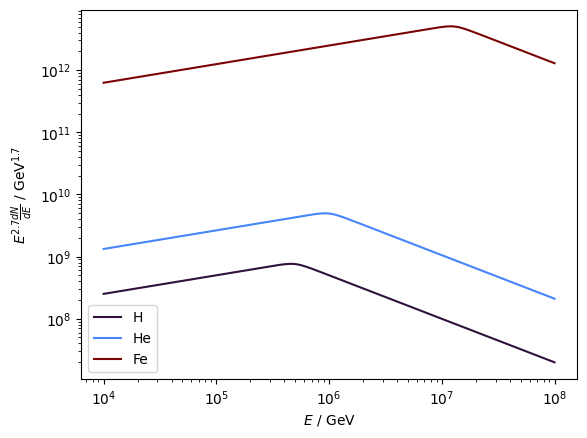

In [31]:
example_cr_model.plot(1e4, 1e8, scale=2.7);

# Experimental data and energy scale shifts


In [32]:
R_MIN = 7e2  # GV
R_MAX = 1e5  # GV

In [33]:
from model.utils import load_data


class GalacticCRExperiment(enum.Enum):
    AMS02 = "AMS-02"
    CALET = "CALET"
    DAMPE = "DAMPE"
    CREAM = "CREAM"

    def available_primaries(self) -> list[Particle]:
        match self:
            case GalacticCRExperiment.AMS02:
                return list(Particle)
            case GalacticCRExperiment.CALET:
                return [
                    Particle.H,
                    # Particle.He,
                    Particle.C,
                    Particle.O,
                    Particle.Fe,
                ]
            case GalacticCRExperiment.DAMPE:
                return [Particle.H, Particle.He]
            case GalacticCRExperiment.CREAM:
                return list(Particle)

    def marker(self) -> str:
        match self:
            case GalacticCRExperiment.AMS02:
                return "o"
            case GalacticCRExperiment.CALET:
                return "s"
            case GalacticCRExperiment.DAMPE:
                return "v"
            case GalacticCRExperiment.CREAM:
                return "*"


@dataclass
class GalacticCRData:
    E: np.ndarray
    dNdE: np.ndarray
    dNdE_errlo: np.ndarray
    dNdE_errhi: np.ndarray

    experiment: GalacticCRExperiment
    particle: Particle

    energy_scale_shift: float = 1.0

    def with_shifted_energy_scale(self, f: float) -> "GalacticCRData":
        return GalacticCRData(
            E=self.E * f,
            dNdE=self.dNdE / f,
            dNdE_errlo=self.dNdE_errlo / f,
            dNdE_errhi=self.dNdE_errhi / f,
            experiment=self.experiment,
            particle=self.particle,
            energy_scale_shift=self.energy_scale_shift * f,
        )

    @classmethod
    def load(cls, exp: GalacticCRExperiment, p: Particle) -> "GalacticCRData":
        data = load_data(
            filename=f"{exp.value}_{p.name}_energy.txt",
            slope=0,  # multiplying data by E^0 = leaving as-is
            norm=1,  # not renormalizing
            min_energy=R_MIN * p.Z,
            max_energy=R_MAX * p.Z,
        )
        return GalacticCRData(
            E=data[0],
            dNdE=data[1],
            dNdE_errlo=data[2],
            dNdE_errhi=data[3],
            experiment=exp,
            particle=p,
        )

    def plot(
        self,
        scale: float,
        ax: plt.Axes | None = None,
        color: Any | None = None,
    ) -> plt.Axes:
        """Note: apply log scaling externally"""
        if ax is None:
            _, ax = plt.subplots()
        E_factor = self.E**scale
        label = f"{self.experiment.value} {self.particle.name}"
        if not np.isclose(self.energy_scale_shift, 1.0):
            label += f" $(E \\times {self.energy_scale_shift:.3g})$"
        ax.errorbar(
            self.E,
            E_factor * self.dNdE,
            yerr=[E_factor * self.dNdE_errlo, E_factor * self.dNdE_errhi],
            color=color or self.particle.color,
            label=label,
            markersize=6.0,
            elinewidth=1.8,
            capthick=1.8,
            fmt=self.experiment.marker(),
        )
        label_axes(ax, scale)
        ax.legend()
        return ax

In [34]:
EXPERIMENTS = [GalacticCRExperiment.AMS02, GalacticCRExperiment.DAMPE]

In [35]:
FitData = dict[GalacticCRExperiment, dict[Particle, GalacticCRData]]
FIT_DATA: FitData = {
    exp: {p: GalacticCRData.load(exp, p) for p in PRIMARY_PARTICLES if p in exp.available_primaries()}
    for exp in EXPERIMENTS
}

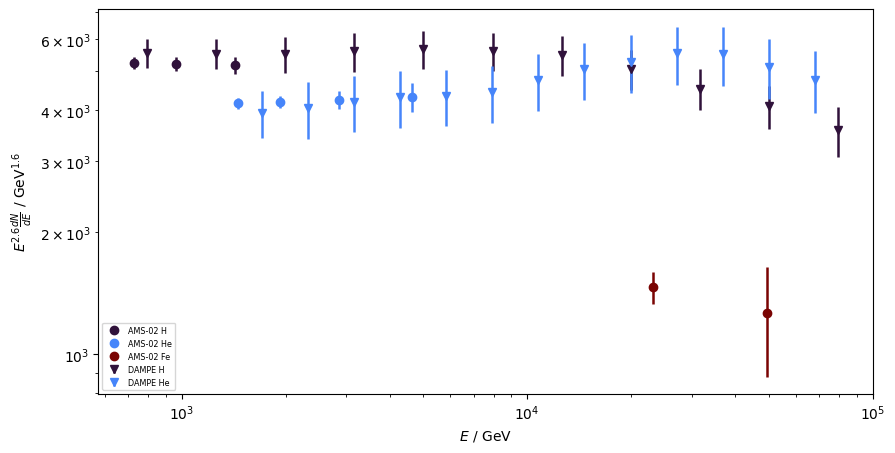

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

for _, p_data in FIT_DATA.items():
    for _, data in p_data.items():
        data.plot(scale=2.6, ax=ax)

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")

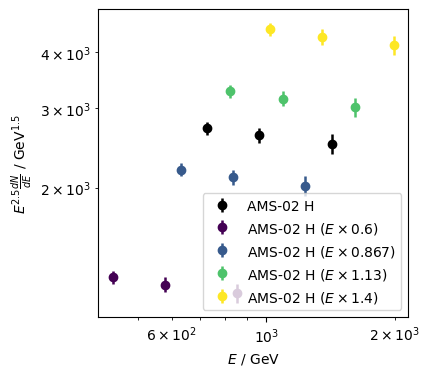

In [37]:
fig, ax = plt.subplots(figsize=(4, 4))
scale = 2.5

cmap = plt.colormaps["viridis"]
fit_data = FIT_DATA[EXPERIMENTS[0]][PRIMARY_PARTICLES[0]]
fit_data.plot(scale, ax=ax, color="black")
for shift in np.linspace(0.6, 1.4, 4):
    fit_data.with_shifted_energy_scale(f=shift).plot(
        scale, ax=ax, color=cmap((shift - 0.7) / (1.3 - 0.7))
    )
ax.set_xscale("log")
ax.set_yscale("log")

In [38]:
@dataclass
class ExperimentEnergyScaleShiftsModel:
    shifts: dict[GalacticCRExperiment, float]

    def pack(self) -> np.ndarray:
        return np.array([self.shifts[exp] for exp in EXPERIMENTS])

    def labels(self) -> list[str]:
        return [f"f_{exp.name}" for exp in EXPERIMENTS]

    @classmethod
    def unpack(
        cls,
        v: np.ndarray,
        start_idx: int = 0,
        experiments: list[GalacticCRExperiment] | None = None,
    ) -> tuple["ExperimentEnergyScaleShiftsModel", int]:
        experiments_coll = experiments or EXPERIMENTS
        shifts = {exp: shift for exp, shift in zip(experiments_coll, v[start_idx:])}
        return ExperimentEnergyScaleShiftsModel(shifts), start_idx + len(
            experiments_coll
        )


example_shifts = ExperimentEnergyScaleShiftsModel({e: 1.0 for e in EXPERIMENTS})
assert (
    example_shifts == ExperimentEnergyScaleShiftsModel.unpack(example_shifts.pack())[0]
)

# Below-knee composition fit


In [39]:
@dataclass
class Model:
    cr: GalacticCRModel
    energy_shifts: ExperimentEnergyScaleShiftsModel

    def pack(self) -> np.ndarray:
        return np.hstack((self.cr.pack(), self.energy_shifts.pack()))

    def labels(self) -> list[str]:
        return self.cr.labels() + self.energy_shifts.labels()

    @classmethod
    def unpack(self, v: np.ndarray) -> "Model":
        cr, end_idx = GalacticCRModel.unpack(v)
        energy_shifts, end_idx = ExperimentEnergyScaleShiftsModel.unpack(v, end_idx)
        assert end_idx == v.size
        return Model(cr=cr, energy_shifts=energy_shifts)

    def plot(self, fit_data: FitData, scale: float) -> None:
        fig, ax = plt.subplots()

        for exp, data_by_particle in fit_data.items():
            for _, data in data_by_particle.items():
                shift = self.energy_shifts.shifts.get(exp, 1.0)
                data.with_shifted_energy_scale(shift).plot(scale=scale, ax=ax)

        primaries = list(self.cr.components.keys())
        self.cr.plot(
            Emin=R_MIN * min(p.Z for p in primaries),
            Emax=R_MAX * max(p.Z for p in primaries),
            scale=scale,
            axes=ax,
        )

        ax.legend(fontsize="xx-small")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(str(self.cr))
        return fig

    def description(self) -> str:
        lines = [
            f"{label} = {value:.2e}" for label, value in zip(self.labels(), self.pack())
        ]
        return "\n".join(lines)


example_mod = Model(cr=example_cr_model, energy_shifts=example_shifts)
packed = example_mod.pack()
print(f"Model parameter vector: {len(packed)} elements")
assert example_mod == Model.unpack(packed)

Model parameter vector: 11 elements


In [40]:
from scipy import stats


DEBUG_PRIOR = False


def debug_log(message: str) -> None:
    if DEBUG_PRIOR:
        print(message)


def logprior(m: Model) -> float:
    for component in m.cr.components.values():
        if component.I < 0:
            debug_log(f"{component}: negative I => prior = 0")
            return -np.inf
        if component.alpha < 0:
            debug_log(f"{component}: negative alpha => prior = 0")
            return -np.inf

    if m.cr.knee_softness < 0:
        debug_log(f"negative knee softness: {m.cr.knee_softness} => prior = 0")
        return -np.inf

    if not R_MIN < m.cr.R_break < 1e8:
        debug_log(f"out of bounds R_break = {m.cr.R_break} => prior = 0")
        return -np.inf

    # TODO: define other informative priors on Galactic CR model

    res = 0
    for experiment, shift in m.energy_shifts.shifts.items():
        if shift < 0:
            debug_log(f"negative shift for {experiment} => prior = 0")
            return -np.inf
        # TODO: look up realistic priors from experiments' systematic uncertainties on energy scale
        sigma = 0.1  # in decades
        res += stats.norm.logpdf(np.log10(shift), loc=0, scale=sigma)
    return res


def loglikelihood(m: Model) -> float:
    loglike = 0
    for experiment, particle_data in FIT_DATA.items():
        for particle, data in particle_data.items():
            data = data.with_shifted_energy_scale(f=m.energy_shifts.shifts[experiment])
            prediction = m.cr.compute(E=data.E, particle=particle)
            loglike_per_bin = - 0.5 * (
                np.where(
                    prediction > data.dNdE,
                    ((prediction - data.dNdE) / data.dNdE_errhi) ** 2,
                    ((prediction - data.dNdE) / data.dNdE_errlo) ** 2,
                )
            )
            if np.any(np.isnan(loglike_per_bin)):
                # print(data, prediction)
                return -np.inf
            loglike += np.sum(loglike_per_bin)
    return loglike


def generate_initial_model() -> Model:
    return Model(
        cr=GalacticCRModel(
            components={
                p: PowerLawComponent(
                    I=(10 ** stats.norm.rvs(loc=-4, scale=0.5)) / (p.Z**2.7),
                    alpha=stats.norm.rvs(loc=2.7, scale=0.1),
                )
                for p in PRIMARY_PARTICLES
            },
            R_break=(
                10 ** stats.norm.rvs(loc=6.4, scale=0.5)
                / np.random.randint(low=1, high=26)
            ),
            d_alpha=stats.norm.rvs(loc=0, scale=1) ** 2,
            knee_softness=10 ** stats.norm.rvs(loc=0.3, scale=0.5),
        ),
        energy_shifts=ExperimentEnergyScaleShiftsModel(
            shifts={exp: 10 ** stats.norm.rvs(loc=0, scale=0.01) for exp in EXPERIMENTS}
        ),
    )

In [41]:
def logpost(v: np.ndarray) -> float:
    model = Model.unpack(v)
    logpi = logprior(model)
    if not np.isfinite(logpi):
        return logpi
    return logpi + loglikelihood(model)

In [42]:
print(generate_initial_model().description())

H_I = 8.93e-04
H_alpha = 2.70e+00
He_I = 7.54e-06
He_alpha = 2.73e+00
Fe_I = 2.06e-08
Fe_alpha = 2.74e+00
R_break = 4.12e+05
d_alpha = 1.09e-01
s_knee = 6.52e+00
f_AMS02 = 1.01e+00
f_DAMPE = 9.75e-01


## Pre-optimization


[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (0.7, 1.3), (0.7, 1.3)]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.877096670036273
             x: [ 1.285e-04  2.573e+00  1.659e-05  2.496e+00  7.654e-09
                  2.778e+00  7.826e+05  1.567e+00  6.729e-01  1.293e+00
                  1.257e+00]
           nit: 3955
          nfev: 5641
 final_simplex: (array([[ 1.285e-04,  2.573e+00, ...,  1.293e+00,
                         1.257e+00],
                       [ 1.285e-04,  2.573e+00, ...,  1.293e+00,
                         1.257e+00],
                       ...,
                       [ 1.285e-04,  2.573e+00, ...,  1.293e+00,
                         1.257e+00],
                       [ 1.285e-04,  2.573e+00, ...,  1.293e+00,
                         1.257e+00]]), array([ 8.771e-01,  8.771e-01,  8.771e-01,  8.771e-01,
             

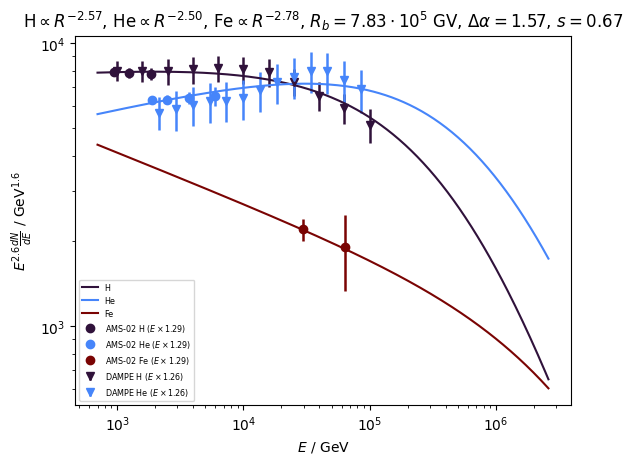

In [43]:
from scipy import optimize

bounds = [(None, None)] * len(generate_initial_model().pack())
# FIXME: unstable dependency on the model packing, assumes energy shifts are packed last
for i in range(len(EXPERIMENTS)):
    bounds[len(bounds) - i - 1] = (0.7, 1.3)
print(bounds)


def minimized_fn(v: np.ndarray) -> float:
    return -logpost(v)


res = optimize.minimize(
    minimized_fn,
    x0=generate_initial_model().pack(),
    method="Nelder-Mead",
    options={
        "maxiter": 100_000,
    },
    bounds=bounds,
)
print(res)

_ = Model.unpack(res.x).plot(FIT_DATA, scale=2.6)

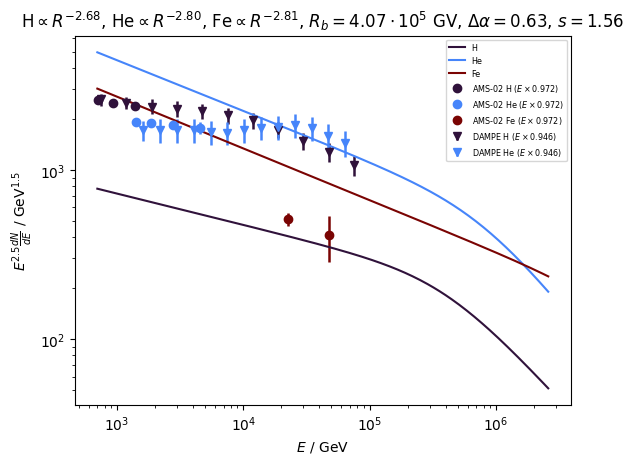

In [44]:
_ = generate_initial_model().plot(fit_data=FIT_DATA, scale=2.5)

In [45]:
import emcee

n_steps = 10_000
n_walkers = 128

n_dim = generate_initial_model().pack().size


sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=n_dim,
    log_prob_fn=logpost,
)
initial_state = np.array([generate_initial_model().pack() for _ in range(n_walkers)])
sampler.run_mcmc(initial_state, nsteps=n_steps, progress=True)
print(f"Acceptance fraction: {sampler.acceptance_fraction.mean()}")

tau = sampler.get_autocorr_time(quiet=True)
print(f"{tau = }")

burn_in = 5 * int(tau.max())
thin = 2 * int(tau.max())
print(f"{burn_in = } {thin = }")

theta_sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)
print(f"MCMC sample ready, shape: {theta_sample.shape}")

  1%|          | 64/10000 [00:00<02:28, 67.10it/s]/tmp/ipykernel_4613/434042423.py:76: RuntimeWarning: overflow encountered in power
  y /= (1.0 + (R / self.R_break) ** self.knee_softness) ** (
  3%|▎         | 314/10000 [00:04<02:15, 71.57it/s]/tmp/ipykernel_4613/4282321225.py:51: RuntimeWarning: overflow encountered in square
  ((prediction - data.dNdE) / data.dNdE_errhi) ** 2,
/tmp/ipykernel_4613/4282321225.py:52: RuntimeWarning: overflow encountered in square
  ((prediction - data.dNdE) / data.dNdE_errlo) ** 2,
  3%|▎         | 346/10000 [00:05<02:12, 72.63it/s]/tmp/ipykernel_4613/434042423.py:76: RuntimeWarning: divide by zero encountered in divide
  y /= (1.0 + (R / self.R_break) ** self.knee_softness) ** (
  5%|▍         | 458/10000 [00:06<02:10, 72.99it/s]/tmp/ipykernel_4613/434042423.py:76: RuntimeWarning: overflow encountered in divide
  y /= (1.0 + (R / self.R_break) ** self.knee_softness) ** (
  6%|▌         | 610/10000 [00:08<02:01, 77.58it/s]/tmp/ipykernel_4613/4282321225

Acceptance fraction: 0.20326953125


N/50 = 200;
tau: [527.68833294 365.84271853 519.17917512 314.71329551 642.18209878
 644.08944259 417.51718387 163.44066971 426.92593785 518.78825215
 524.26128466]


tau = array([527.68833294, 365.84271853, 519.17917512, 314.71329551,
       642.18209878, 644.08944259, 417.51718387, 163.44066971,
       426.92593785, 518.78825215, 524.26128466])
burn_in = 3220 thin = 1288
MCMC sample ready, shape: (640, 11)


In [46]:
theta_sample.shape

(640, 11)

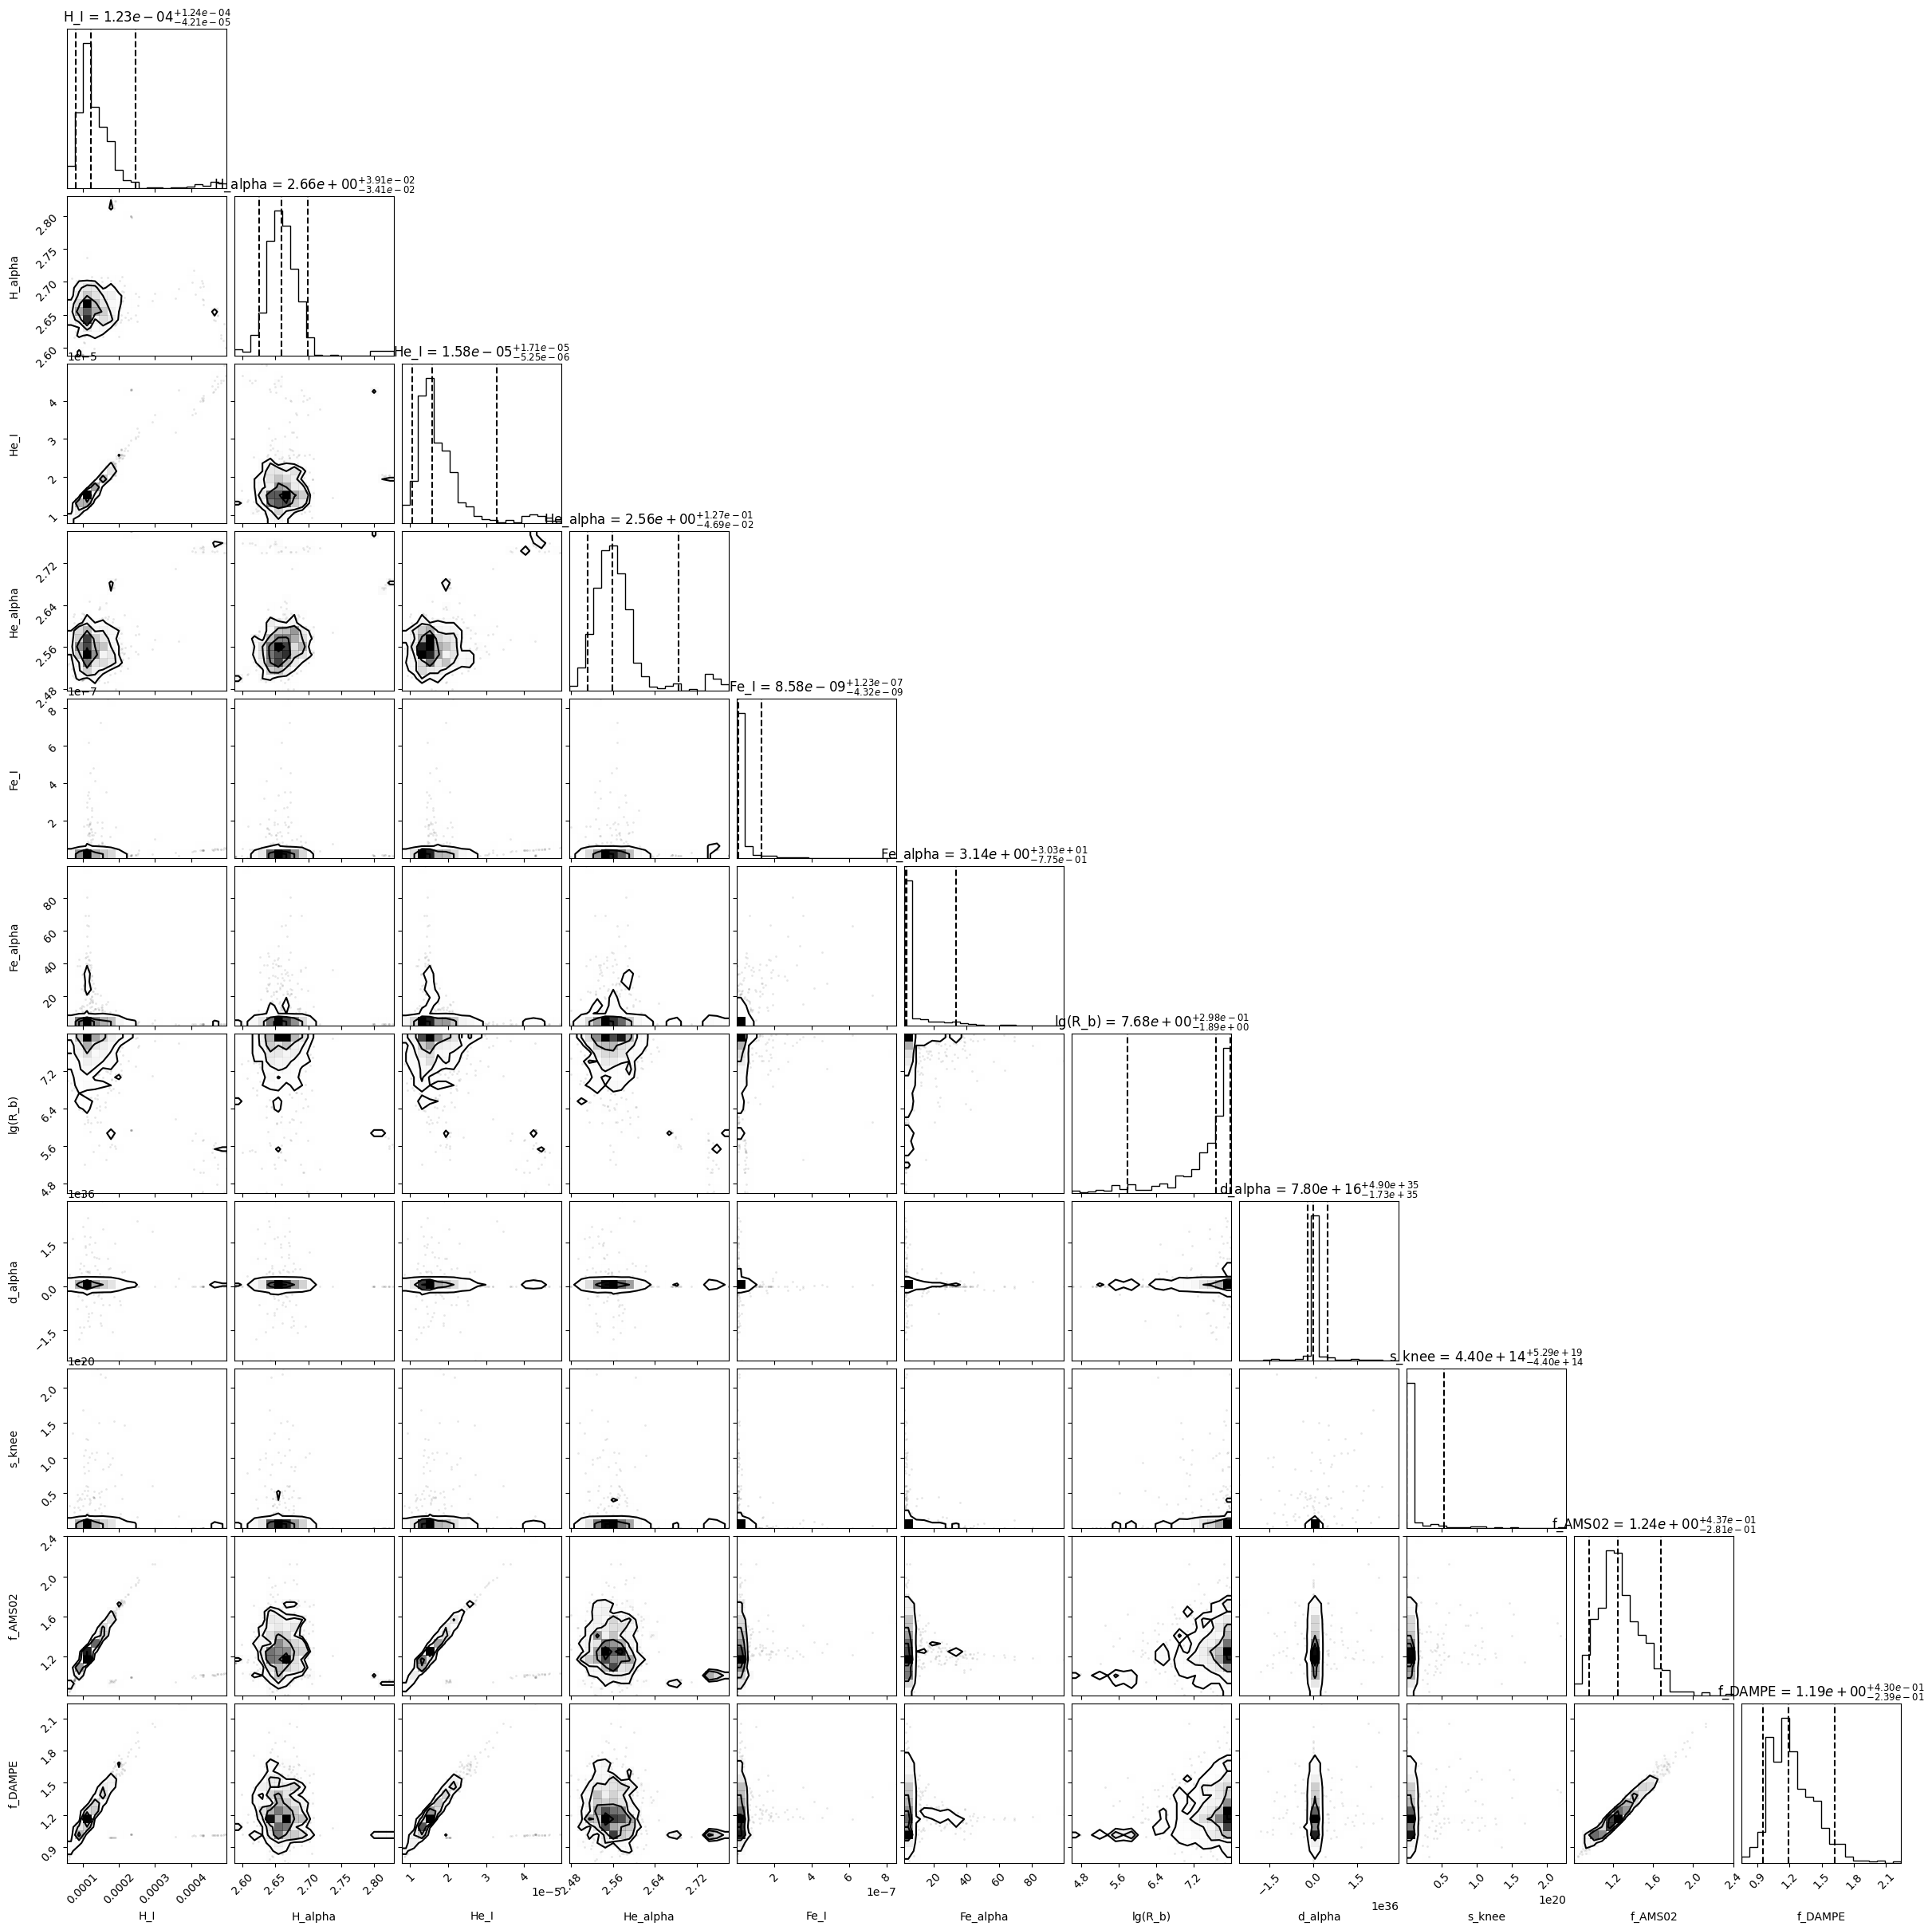

In [47]:
import corner

sample_to_plot = theta_sample
sample_labels = generate_initial_model().labels()

R_break_dim = generate_initial_model().labels().index("R_break")
sample_to_plot[:, R_break_dim] = np.log10(sample_to_plot[:, R_break_dim])
sample_labels[R_break_dim] = "lg(R_b)"

_ = corner.corner(
    sample_to_plot,
    labels=sample_labels,
    show_titles=True,
    title_fmt=".2e",
    quantiles=[0.05, 0.5, 0.95],
)